In [1]:
import os
os.chdir("/content/drive/Shareddrives/yujung kim/Study/Python/time_series")

In [2]:
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta, time

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm.auto import tqdm
from typing import Optional, Tuple

In [4]:
with open('data/pv.pickle', 'rb') as f:
    pv = pickle.load(f)

# scaling

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
power_scaler = MinMaxScaler()
power_scaler.fit(pv[['power']])
pv['power_scale'] = power_scaler.transform(pv[['power']])

In [7]:
x_scaler = MinMaxScaler()
x_scaler.fit(pv[['alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']])
pv[['alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']] = x_scaler.transform(pv[['alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']])

In [8]:
pv = pv.set_index('datetime')

In [9]:
tz = timezone(timedelta(hours=-6))
pv_train = pv.loc[:datetime(2006,11,30,23,tzinfo=tz)]
pv_val = pv.loc[datetime(2006,11,24,00,tzinfo=tz):datetime(2006,12,20,23,tzinfo=tz)]
pv_test = pv.loc[datetime(2006,12,14,00,tzinfo=tz):datetime(2006,12,31,23,tzinfo=tz)]

# data loader

In [10]:
from torch.utils.data import DataLoader, Dataset

In [11]:
class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, num_feature, data_comp, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        # seq_len
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output : shape = (window 크기, sample 개수)
        X = np.zeros([input_window, num_samples, num_feature])
        Y = np.zeros([output_window, num_samples, num_feature])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i,:] = y[start_x:end_x]
            # print(X.shape)

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]
            # print(Y.shape)

        X = X.reshape(X.shape[0], X.shape[1], num_feature).transpose((1,0,2)) # (seq_len, input_window, feature)
        Y = Y.reshape(Y.shape[0], Y.shape[1], num_feature).transpose((1,0,2)) # (seq_len, output_window, 1=power)

        if data_comp==1:
            # Y = Y[:,:,0][:,:,None]
            print(Y.shape)

        if data_comp==2:
            X = Y[:,:,1:].copy()
            Y = Y[:,:,0][:,:,None]
            print(X.shape)
            print(Y.shape)
        
        self.x = X
        self.y = Y
        self.len = len(X)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return self.len

# model

In [12]:
"""
multihead attention layer 에서 attention energy 값 저장하도록 class 수정
need_weights=True 로 설정
"""

def attn_forward(self, query: Tensor, key: Tensor, value: Tensor, key_padding_mask: Optional[Tensor] = None,
            need_weights: bool = True, attn_mask: Optional[torch.Tensor] = None,
            average_attn_weights: bool = True) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
    is_batched = query.dim() == 3
    if self.batch_first and is_batched:
        query, key, value = [x.transpose(1, 0) for x in (query, key, value)]

    if not self._qkv_same_embed_dim:
        attn_output, attn_output_weights = F.multi_head_attention_forward(
            query, key, value, self.embed_dim, self.num_heads,
            self.in_proj_weight, self.in_proj_bias,
            self.bias_k, self.bias_v, self.add_zero_attn,
            self.dropout, self.out_proj.weight, self.out_proj.bias,
            training=self.training,
            key_padding_mask=key_padding_mask, need_weights=True,
            attn_mask=attn_mask, use_separate_proj_weight=True,
            q_proj_weight=self.q_proj_weight, k_proj_weight=self.k_proj_weight,
            v_proj_weight=self.v_proj_weight, average_attn_weights=average_attn_weights)
    else:
        attn_output, attn_output_weights = F.multi_head_attention_forward(
            query, key, value, self.embed_dim, self.num_heads,
            self.in_proj_weight, self.in_proj_bias,
            self.bias_k, self.bias_v, self.add_zero_attn,
            self.dropout, self.out_proj.weight, self.out_proj.bias,
            training=self.training,
            key_padding_mask=key_padding_mask, need_weights=True,
            attn_mask=attn_mask, average_attn_weights=average_attn_weights)
    
    # property 추가
    self.attn = attn_output_weights

    if self.batch_first and is_batched:
        return attn_output.transpose(1, 0), attn_output_weights
    else:
        return attn_output, attn_output_weights

In [13]:
def pos_encoding(dim, max_len):
    pe = torch.Tensor(max_len, dim)
    pos = torch.arange(0, max_len, 1.0).unsqueeze(1)
    k = torch.exp(-np.log(10000)*torch.arange(0, dim, 2.0)/dim)
    pe[:,0::2] = torch.sin(pos*k)
    pe[:,1::2] = torch.cos(pos*k)
    return pe

In [27]:
class transformer(nn.Module):
    def __init__(self, d_model, nhead, num_encoder_layers=1, num_decoder_layers=1, dim_feedforward=128): 
        super(transformer, self).__init__() 
        self.d_model = d_model
        self.nhead = nhead
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        self.dim_feedforward = dim_feedforward

        # batch_first=True 인 경우 (batch, input_window, feature) 에 맞춰서 input
        self.transformer = nn.Transformer(d_model=self.d_model, 
                                          nhead=self.nhead,
                                          num_encoder_layers=self.num_encoder_layers,
                                          num_decoder_layers=self.num_decoder_layers,
                                          dim_feedforward=self.dim_feedforward,
                                          batch_first=True) 
        self.linear = nn.Linear(self.d_model, 1)

    def forward(self, src, tgt, tgt_mask=None):
        src = src + pos_encoding(self.d_model, iw)
        tgt = tgt + pos_encoding(self.d_model, ow)

        hidden = self.transformer(src, tgt, tgt_mask=tgt_mask)
        output = self.linear(hidden)
        return output

# train

In [ ]:
        dec_src = x[:,-1,:].unsqueeze(1)
        attention = torch.Tensor().to(device)
        output = torch.Tensor().to(device)

        for _ in range(max_len):
            target_mask = model.transformer.generate_square_subsequent_mask(dec_src.shape[1]).to(device)

            with torch.no_grad():
                dec_src2 = dec_src + pos_encoding(dec_src.shape[2], dec_src.shape[1])
                hidden = model.transformer.decoder(dec_src2, enc_src, target_mask)
                out = model.linear(hidden)
            attn_ = model.transformer.decoder.layers[0].multihead_attn.attn[:,-1,:].unsqueeze(1)

            dec_src = torch.cat([dec_src, hidden[:,-1,:].unsqueeze(1)], dim=1)
            output = torch.cat([output, out[:,-1,:].unsqueeze(1)], dim=1)
            attention = torch.cat([attention, attn_], dim=1)

In [51]:
# teacher forcing = 0
# decoding 을 max len 만큼 반복해야해서 시간이 훨씬 길어짐

def train(model, train_loader, max_len, optimizer, criterion, gradient_clipping=False, device='cuda'):
    model.train()
    total_loss = 0.0
    outputs = []
    ys = []
    attention_list = []

    for x, y in train_loader:
        optimizer.zero_grad()
        x = x.to(device).float()
        y = y.to(device).float()

        enc_src = x + pos_encoding(x.shape[2], x.shape[1])
        enc_src = model.transformer.encoder(enc_src)

        dec_src = x[:,-1,:].unsqueeze(1)
        attention = torch.Tensor().to(device)
        output = torch.Tensor().to(device)

        for _ in range(max_len):
            target_mask = model.transformer.generate_square_subsequent_mask(dec_src.shape[1]).to(device)

            dec_src2 = dec_src + pos_encoding(dec_src.shape[2], dec_src.shape[1])
            hidden = model.transformer.decoder(dec_src2, enc_src, target_mask)
            out = model.linear(hidden)
            attn_ = model.transformer.decoder.layers[0].multihead_attn.attn[:,-1,:].unsqueeze(1)

            dec_src = torch.cat([dec_src, hidden[:,-1,:].unsqueeze(1)], dim=1)
            output = torch.cat([output, out[:,-1,:].unsqueeze(1)], dim=1)
            attention = torch.cat([attention, attn_], dim=1)

        attention_list.append(list(attention.detach().cpu().numpy()))
        outputs.append(list(output.detach().cpu().numpy()))
        ys.append(list(y.detach().cpu().numpy()))

        loss = criterion(output[:,:,0], y[:,:,0])
        # loss = criterion(output, y_out[:,:,0])
        loss.backward()
        if gradient_clipping:
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
        optimizer.step()
        total_loss += loss.cpu().item()
    train_loss = total_loss/len(train_loader)

    return np.array(sum(outputs,[])), np.array(sum(ys,[])), np.array(sum(attention_list,[])), train_loss

In [72]:
def predict(model, test_loader, max_len, criterion, device='cuda', file_name=None):
    model.eval()

    total_loss = 0.0
    outputs = []
    ys = []
    attention_list = []

    for t, (x, y) in enumerate(test_loader):
        x = x.to(device).float()
        y = y.to(device).float()

        with torch.no_grad():
            enc_src = x + pos_encoding(x.shape[2], x.shape[1])
            enc_src = model.transformer.encoder(enc_src)

        dec_src = x[:,-1,:].unsqueeze(1)
        attention = torch.Tensor().to(device)
        output = torch.Tensor().to(device)

        for _ in range(max_len):
            target_mask = model.transformer.generate_square_subsequent_mask(dec_src.shape[1]).to(device)

            with torch.no_grad():
                dec_src2 = dec_src + pos_encoding(dec_src.shape[2], dec_src.shape[1])
                hidden = model.transformer.decoder(dec_src2, enc_src, target_mask)
                out = model.linear(hidden)
                attn_ = model.transformer.decoder.layers[0].multihead_attn.attn[:,-1,:].unsqueeze(1)

            dec_src = torch.cat([dec_src, hidden[:,-1,:].unsqueeze(1)], dim=1)
            output = torch.cat([output, out[:,-1,:].unsqueeze(1)], dim=1)
            attention = torch.cat([attention, attn_], dim=1)

        attention_list.append(list(attention.detach().cpu().numpy()))
        outputs.append(list(output.detach().cpu().numpy()))
        ys.append(list(y.detach().cpu().numpy()))

        loss = criterion(output[:,:,0], y[:,:,0])
        total_loss += loss.cpu().item()

    test_loss = total_loss/len(test_loader)
    # print(f"test loss: {(total_loss/len(test_loader)):.5f}")

    return np.array(sum(outputs,[])), np.array(sum(ys,[])), np.array(sum(attention_list, [])), test_loss

In [73]:
iw = 24*7
ow = 24
num_feature = 8

train_dataset = windowDataset(pv_train[['power_scale', 'alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']], 
                              input_window=iw, output_window=ow, num_feature=num_feature, data_comp=1, stride=ow)
valid_dataset = windowDataset(pv_val[['power_scale', 'alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']], 
                             input_window=iw, output_window=ow, num_feature=num_feature, data_comp=1, stride=ow)
test_dataset = windowDataset(pv_test[['power_scale', 'alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']], 
                             input_window=iw, output_window=ow, num_feature=num_feature, data_comp=1, stride=ow)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

(327, 24, 8)
(20, 24, 8)
(11, 24, 8)


In [74]:
a = next(iter(train_loader))
print(a[0].shape)
print(a[1].shape)

torch.Size([64, 168, 8])
torch.Size([64, 24, 8])


In [96]:
param_config = {
    "learning_rate": 0.001,
    "epochs": 1000,
    "d_model": 8,
    "nhead": 4,
    "num_encoder_layers": 1,
    "num_decoder_layers": 1,
    "dim_feedforward": 128
}

In [97]:
device='cpu'
model = transformer(d_model=param_config["d_model"], 
                       nhead=param_config["nhead"], 
                       num_encoder_layers=param_config["num_encoder_layers"], 
                       num_decoder_layers=param_config["num_decoder_layers"], 
                       dim_feedforward=param_config["dim_feedforward"]).to(device)

optimizer = optim.Adam(model.parameters(), lr = param_config['learning_rate'])
criterion = nn.MSELoss()

In [98]:
# multihead attention layer 에서 수정
model.transformer.decoder.layers[0].multihead_attn.__class__._forward = attn_forward
for layer in model.transformer.decoder.layers:
    layer.multihead_attn.forward = layer.multihead_attn._forward

In [99]:
# 파라미터 수 계산
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,353 trainable parameters


In [100]:
# # 파라미터 초기화
# def initialize_weights(m):
#     if hasattr(m, 'weight') and m.weight.dim() > 1:
#         nn.init.xavier_uniform_(m.weight.data)

# model.apply(initialize_weights)

In [101]:
target_mask = model.transformer.generate_square_subsequent_mask(ow).to(device)

In [102]:
# wandb.watch(model, log='all', log_freq=10)

val_loss_min = 100
file_name = 'model/basic.model'

pbar = tqdm(range(param_config['epochs']))
for epoch in pbar:
    *result_train, train_loss = train(model, train_loader, ow, optimizer, criterion, gradient_clipping=3, device=device)
    *result_val, val_loss = predict(model, val_loader, ow, criterion, device=device)
    *result_test, test_loss = predict(model, test_loader, ow, criterion, device=device)

    if val_loss < val_loss_min:
        val_loss_min = val_loss
        torch.save(model.state_dict(), file_name)
        print(f"epoch: {epoch} / val_loss: {val_loss:.5f} / test_loss: {test_loss:.5f}")

    # wandb.log({"train_loss": train_loss, "val_loss": val_loss, "test_loss": test_loss, "val_loss_min": val_loss_min})

    pbar.set_postfix(loss=f"train_loss: {train_loss:.5f} / val_loss: {val_loss:.5f} / test_loss: {test_loss:.5f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 0 / val_loss: 0.10949 / test_loss: 0.10445
epoch: 2 / val_loss: 0.08237 / test_loss: 0.06287
epoch: 3 / val_loss: 0.07872 / test_loss: 0.04691
epoch: 4 / val_loss: 0.07771 / test_loss: 0.04849
epoch: 7 / val_loss: 0.07657 / test_loss: 0.05343
epoch: 8 / val_loss: 0.07507 / test_loss: 0.05085
epoch: 9 / val_loss: 0.07506 / test_loss: 0.05393
epoch: 10 / val_loss: 0.07379 / test_loss: 0.05359
epoch: 11 / val_loss: 0.07109 / test_loss: 0.05033
epoch: 12 / val_loss: 0.06873 / test_loss: 0.04957
epoch: 13 / val_loss: 0.06576 / test_loss: 0.04884
epoch: 14 / val_loss: 0.06090 / test_loss: 0.04708
epoch: 15 / val_loss: 0.05352 / test_loss: 0.04555
epoch: 16 / val_loss: 0.04234 / test_loss: 0.04619
epoch: 17 / val_loss: 0.03289 / test_loss: 0.05411
epoch: 18 / val_loss: 0.02588 / test_loss: 0.05271
epoch: 19 / val_loss: 0.01901 / test_loss: 0.04163
epoch: 21 / val_loss: 0.01507 / test_loss: 0.04785
epoch: 23 / val_loss: 0.01477 / test_loss: 0.04801
epoch: 24 / val_loss: 0.01349 / test_l

In [103]:
pred_val = result_val[0]
pred_val = power_scaler.inverse_transform(pred_val[:,:,0].reshape(-1,1))
print(f"pred_val: {len(pred_val)}")

pred_test = result_test[0]
pred_test = power_scaler.inverse_transform(pred_test[:,:,0].reshape(-1,1))
print(f"pred_test: {len(pred_test)}")

pred_val: 480
pred_test: 264


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

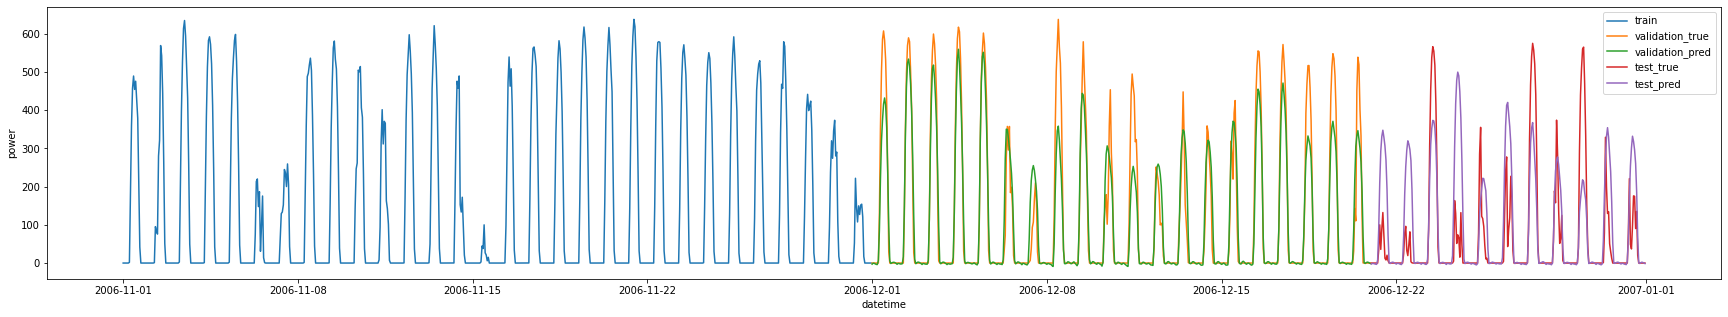

In [104]:
plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):]['power'], label='train')
sns.lineplot(pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'], label='validation_true')
sns.lineplot(pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pred_val.reshape(-1), label='validation_pred')
sns.lineplot(pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):].index, pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):]['power'], label='test_true')
sns.lineplot(pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):].index, pred_test.reshape(-1), label='test_pred')
plt.legend()

In [105]:
*result_train, train_loss = predict(model, train_loader, ow, criterion, device=device)

In [106]:
train_loss

0.008699422236531973

In [107]:
model.load_state_dict(torch.load(file_name))
*result_val, val_loss = predict(model, val_loader, ow, criterion, device=device)
*result_test, test_loss = predict(model, test_loader, ow, criterion, device=device)

In [108]:
pred_val = result_val[0]
pred_val = power_scaler.inverse_transform(pred_val[:,:,0].reshape(-1,1))
print(f"pred_val: {len(pred_val)}")

pred_test = result_test[0]
pred_test = power_scaler.inverse_transform(pred_test[:,:,0].reshape(-1,1))
print(f"pred_test: {len(pred_test)}")

pred_val: 480
pred_test: 264


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

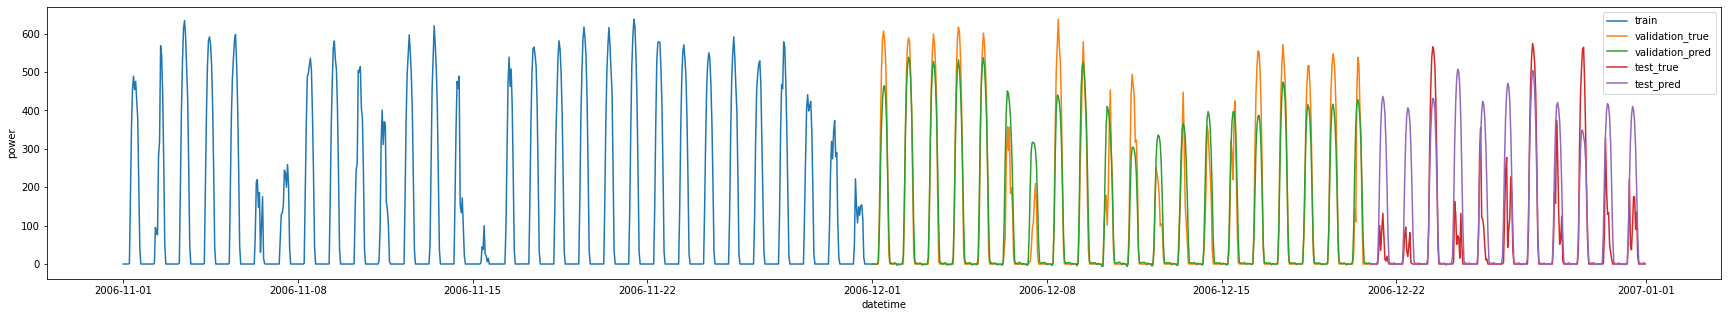

In [109]:
plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):]['power'], label='train')
sns.lineplot(pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'], label='validation_true')
sns.lineplot(pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pred_val.reshape(-1), label='validation_pred')
sns.lineplot(pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):].index, pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):]['power'], label='test_true')
sns.lineplot(pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):].index, pred_test.reshape(-1), label='test_pred')
plt.legend()

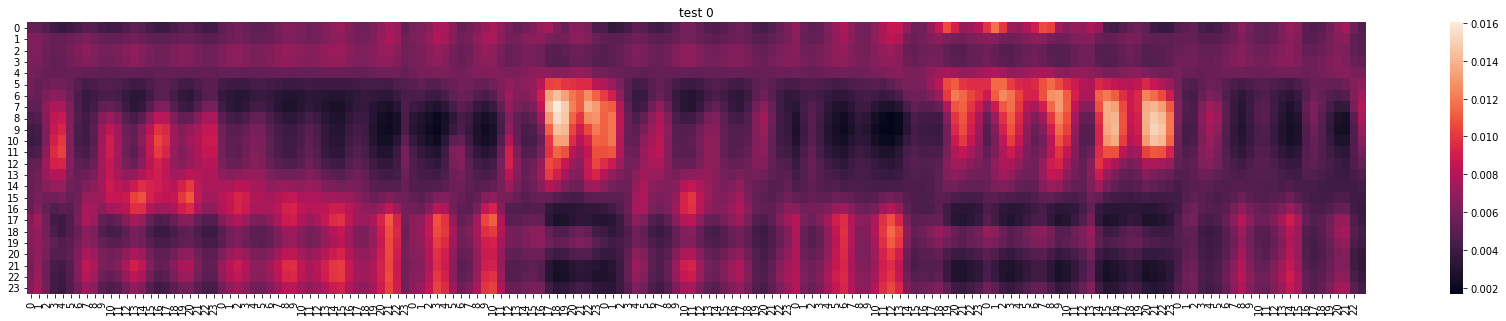

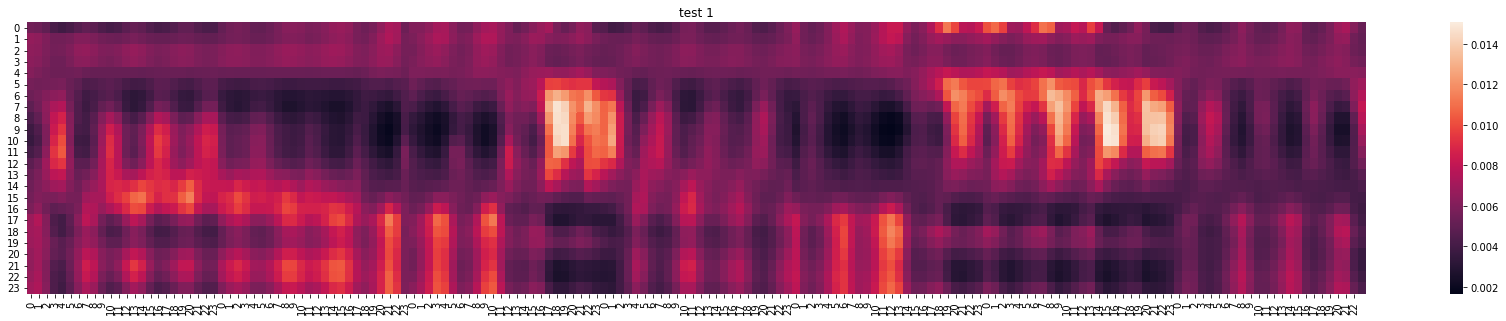

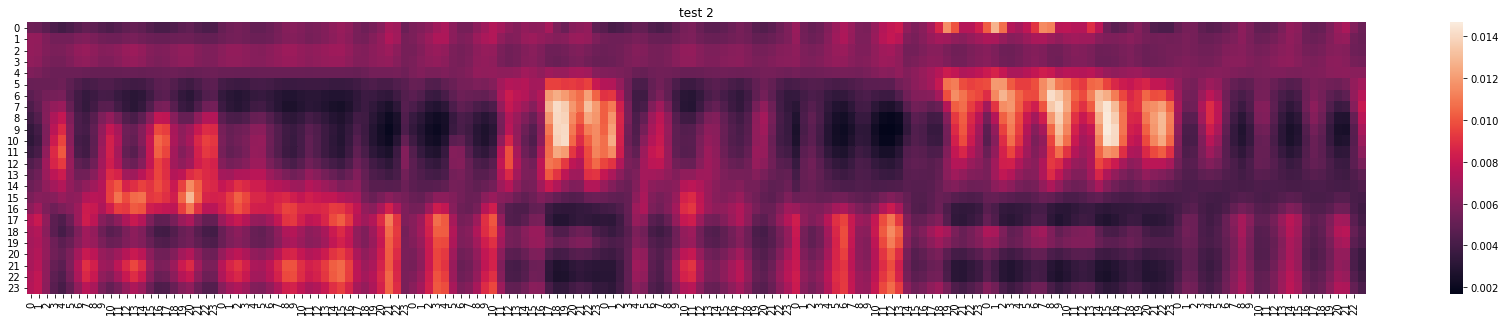

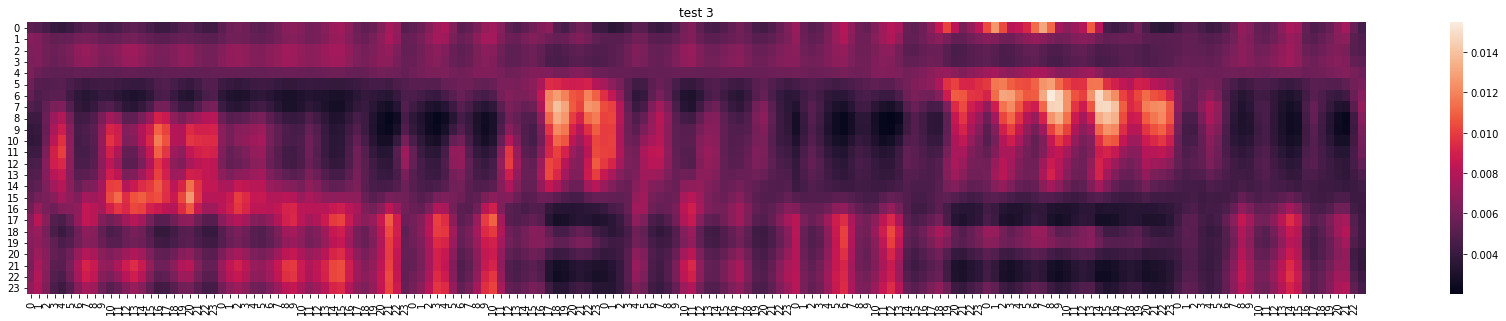

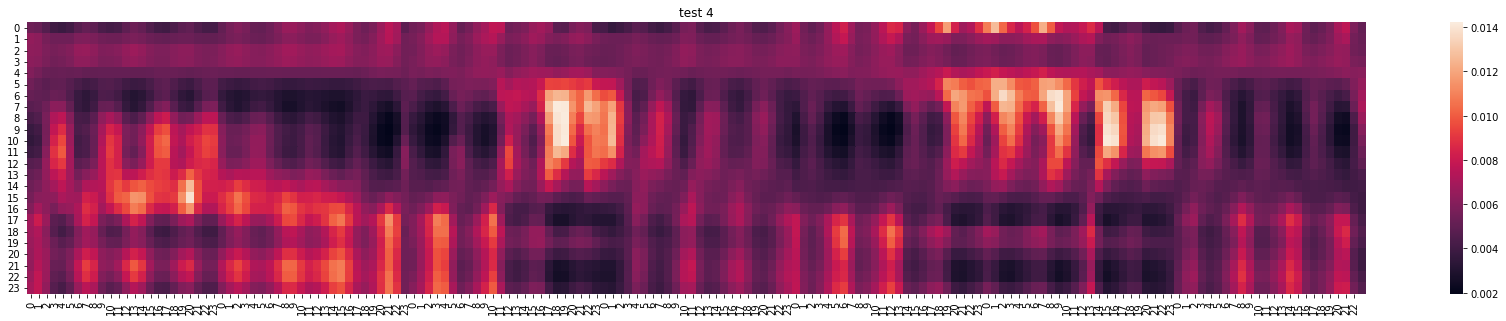

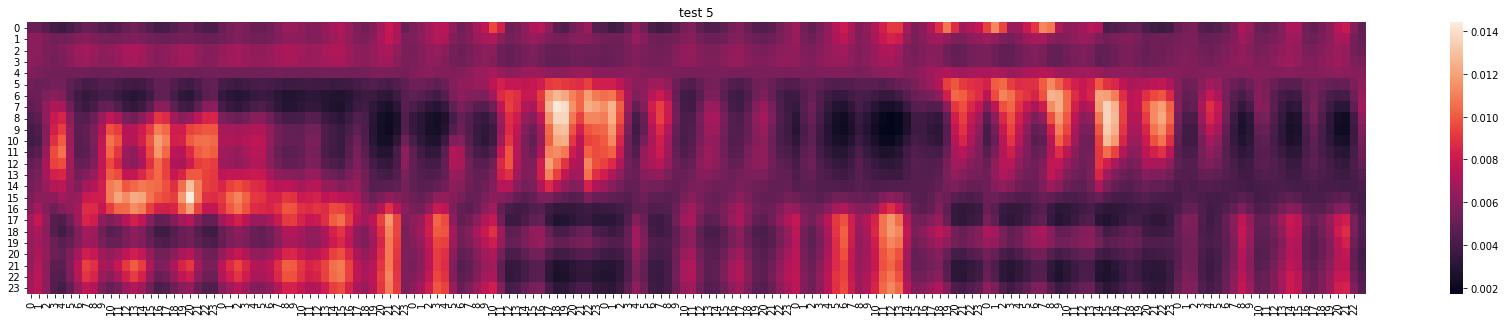

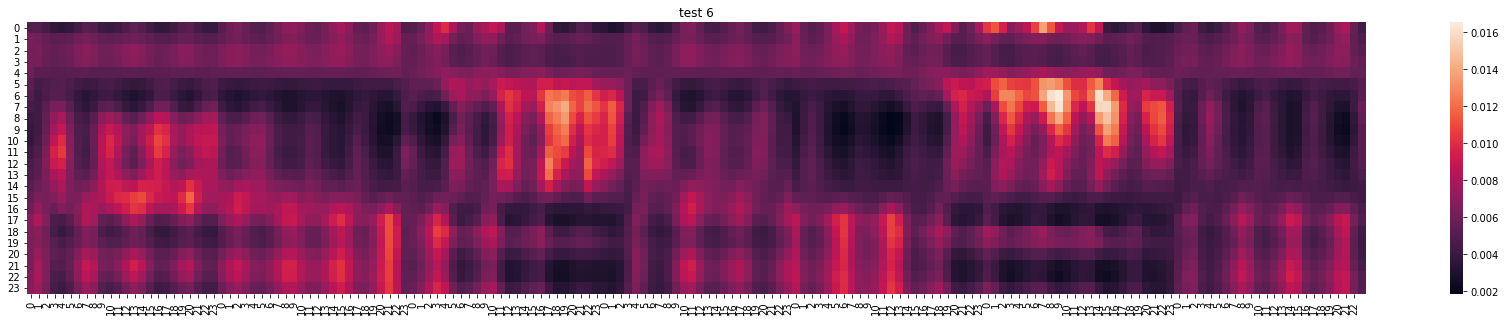

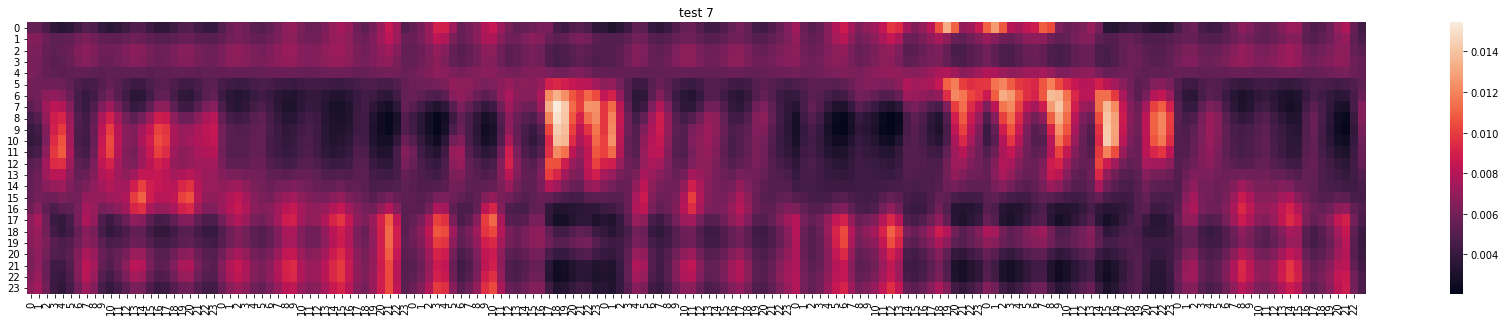

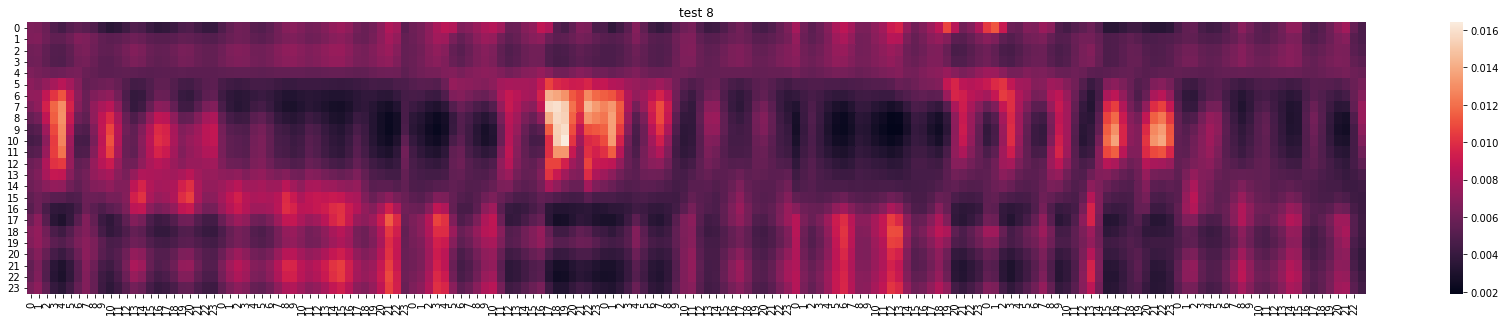

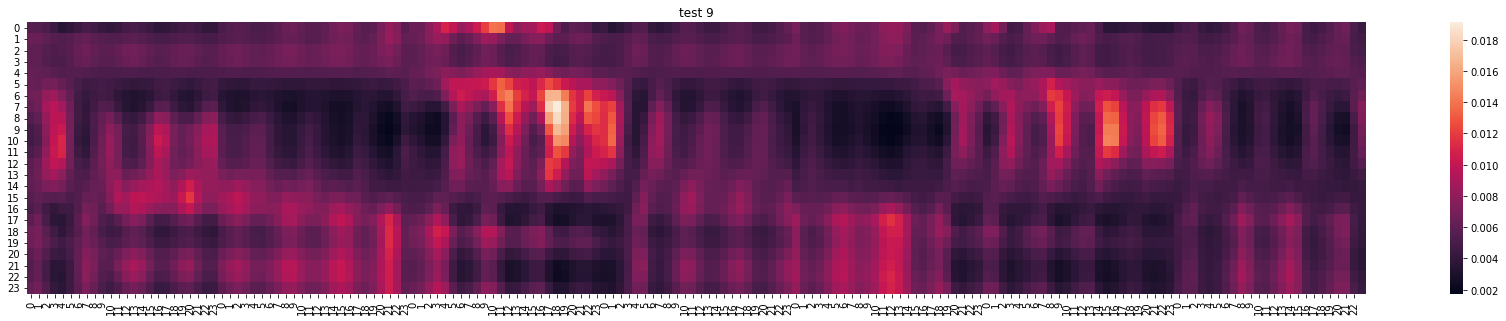

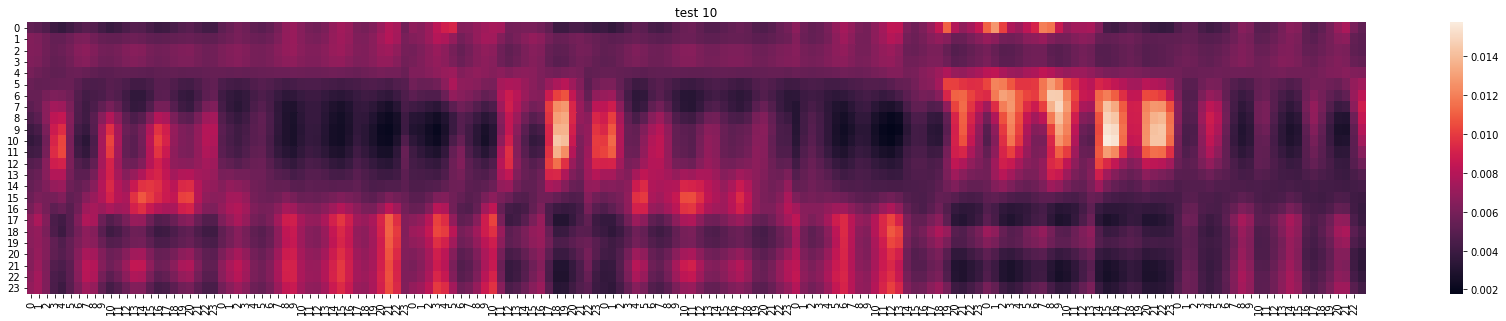

In [110]:
# test set 태양열 발전량 예측에 대한 attention energy 시각화
attention = result_test[2]

for i, att in enumerate(attention):
    plt.figure(figsize=(30,5))
    sns.heatmap(att, xticklabels=[i%24 for i in range(167)])
    plt.title(f"test {i}")
    plt.show()